<a href="https://colab.research.google.com/github/arunjegathesh/airbnb_ensemble_learning/blob/main/DSBA_Ensemble_Learning_airbnb_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing the required libraries

In [1]:
!pip install catboost
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 10.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 31.1 MB/s eta 0:00:00


In [2]:
#Importing basic data processing, plotting & boosting/bagging models & model evaluation libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
#from sklearn.preprocessing import scale, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pickle
from joblib import dump, load
import shap

#Data Import & EDA along with data cleaning

In [3]:
#Mounting google drive location for laoding input data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df_in = pd.read_csv('/content/drive/MyDrive/Ensemble_Project/AB_NYC_2019.csv')

In [7]:
#Exploring the structure of the dataframe & column values for basic idea of the dataset
df_in.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [8]:
#Checking the column level count of null or NA values
df_in.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [9]:
#For some categorical/numerical variables, printing the unique values
cols = ['neighbourhood_group','neighbourhood','minimum_nights','room_type','calculated_host_listings_count']

for y in cols:
  uni = df_in[y].unique()
  print(f"{y}:{uni}")

neighbourhood_group:['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']
neighbourhood:['Kensington' 'Midtown' 'Harlem' 'Clinton Hill' 'East Harlem'
 'Murray Hill' 'Bedford-Stuyvesant' "Hell's Kitchen" 'Upper West Side'
 'Chinatown' 'South Slope' 'West Village' 'Williamsburg' 'Fort Greene'
 'Chelsea' 'Crown Heights' 'Park Slope' 'Windsor Terrace' 'Inwood'
 'East Village' 'Greenpoint' 'Bushwick' 'Flatbush' 'Lower East Side'
 'Prospect-Lefferts Gardens' 'Long Island City' 'Kips Bay' 'SoHo'
 'Upper East Side' 'Prospect Heights' 'Washington Heights' 'Woodside'
 'Brooklyn Heights' 'Carroll Gardens' 'Gowanus' 'Flatlands' 'Cobble Hill'
 'Flushing' 'Boerum Hill' 'Sunnyside' 'DUMBO' 'St. George' 'Highbridge'
 'Financial District' 'Ridgewood' 'Morningside Heights' 'Jamaica'
 'Middle Village' 'NoHo' 'Ditmars Steinway' 'Flatiron District'
 'Roosevelt Island' 'Greenwich Village' 'Little Italy' 'East Flatbush'
 'Tompkinsville' 'Astoria' 'Clason Point' 'Eastchester' 'Kingsbridge'
 'Two Bridges' 

In [10]:
#For every column in the dataframe, printing the total rows & distinct count of elements in them
for x in df_in.columns:
  cnt = df_in[x].count()
  uni = df_in[x].nunique()
  print(f"{x} : {cnt}/{uni}")

id : 48895/48895
name : 48879/47905
host_id : 48895/37457
host_name : 48874/11452
neighbourhood_group : 48895/5
neighbourhood : 48895/221
latitude : 48895/19048
longitude : 48895/14718
room_type : 48895/3
price : 48895/674
minimum_nights : 48895/109
number_of_reviews : 48895/394
last_review : 38843/1764
reviews_per_month : 38843/937
calculated_host_listings_count : 48895/47
availability_365 : 48895/366


In [11]:
#Printing the dataframe details as info list for understanding
df_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

#Categorical Variables Distribution

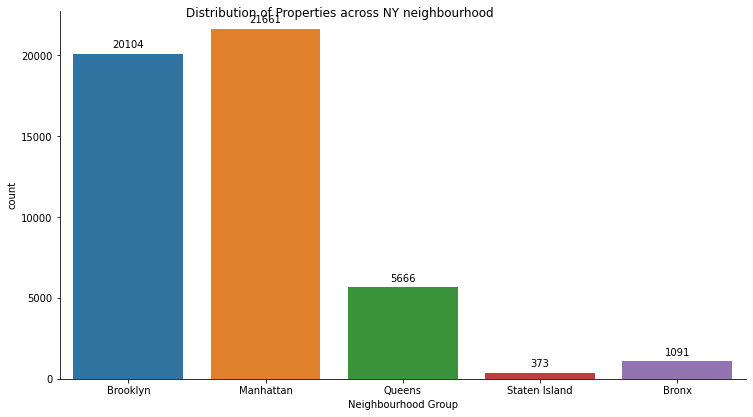

In [12]:
#Plotting a distribution of the data across different neighbourhood values

plot = sns.catplot(x='neighbourhood_group', kind='count' ,data=df_in)
plot.fig.suptitle('Distribution of Properties across NY neighbourhood')
plot.set(xlabel = 'Neighbourhood Group')

ax = plot.facet_axis(0,0)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')


plot.fig.set_size_inches(12,6)

plt.show()

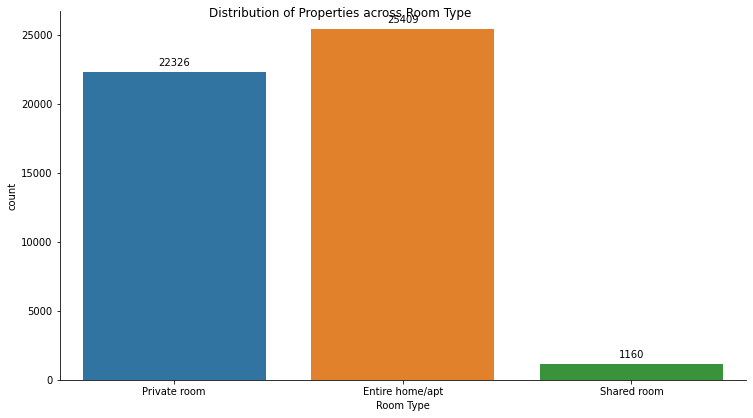

In [13]:
#Plotting a distribution of the data across different Room Type values

plot = sns.catplot(x='room_type', kind='count' ,data=df_in)
plot.fig.suptitle('Distribution of Properties across Room Type')
plot.set(xlabel = 'Room Type')

ax = plot.facet_axis(0,0)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')


plot.fig.set_size_inches(12,6)

plt.show()

#Numerical Variables' Distribution

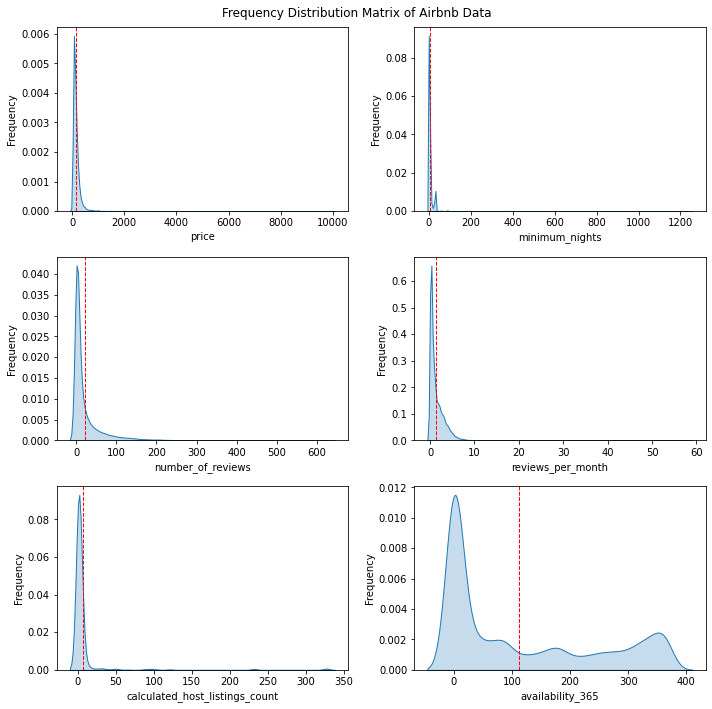

In [14]:
#Similar to the categorical variables, plotting the numerical variables using a distribution plot along with their mean values (dotted red line)

fig, axs = plt.subplots(3, 2, figsize=(10, 10))

cols = ['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

for idx, col in enumerate(cols):
    row = idx // 2
    col1 = idx % 2
    sns.kdeplot(ax=axs[row, col1], data=df_in, x=col, shade=True)
    axs[row, col1].set_xlabel(col)
    axs[row, col1].set_ylabel('Frequency')
    
    axs[row, col1].axvline(x=df_in[col].mean(), color='red', linestyle='dashed', linewidth=1)
    
fig.suptitle('Frequency Distribution Matrix of Airbnb Data')

plt.tight_layout()
plt.show()


In [16]:
#Numerical variables described to see the min, max and average values

df_in[['price','minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365']].describe()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [18]:
#Checking for rows that has no price - only 11 rows with no price

(df_in.price == 0).astype(int).sum()

11

Text(0.5, 0.98, 'Frequency Distribution of transformation with sqrt and log1p functions on Price')

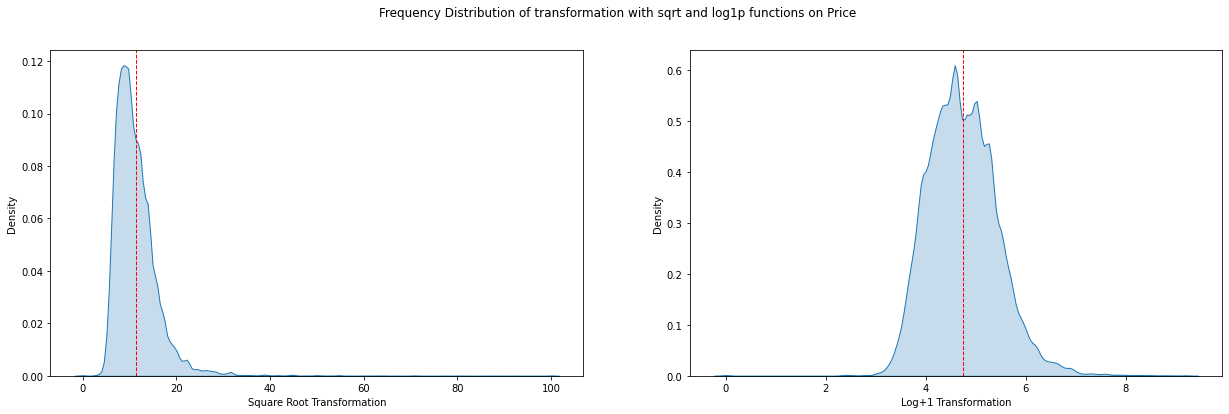

In [19]:
#To tackle the skewness in the price variable, transformation being plotted to see if the data looks more normally distributed

fig, axes = plt.subplots(1,2, figsize=(21,6))
sns.kdeplot(np.sqrt(df_in['price']), ax =axes[0], shade = 'True')
axes[0].axvline(x=(np.sqrt(df_in['price'])).mean(), color='red', linestyle='dashed', linewidth=1)
axes[0].set_xlabel('Square Root Transformation')

sns.kdeplot(np.log1p(df_in['price']), ax = axes[1], shade = 'True')
axes[1].axvline(x=(np.log1p(df_in['price'])).mean(), color='red', linestyle='dashed', linewidth=1)
axes[1].set_xlabel('Log+1 Transformation')

fig.suptitle('Frequency Distribution of transformation with sqrt and log1p functions on Price')

Text(0.5, 0.98, 'Frequency Distribution of transformation with log1p function on minimum_nights')

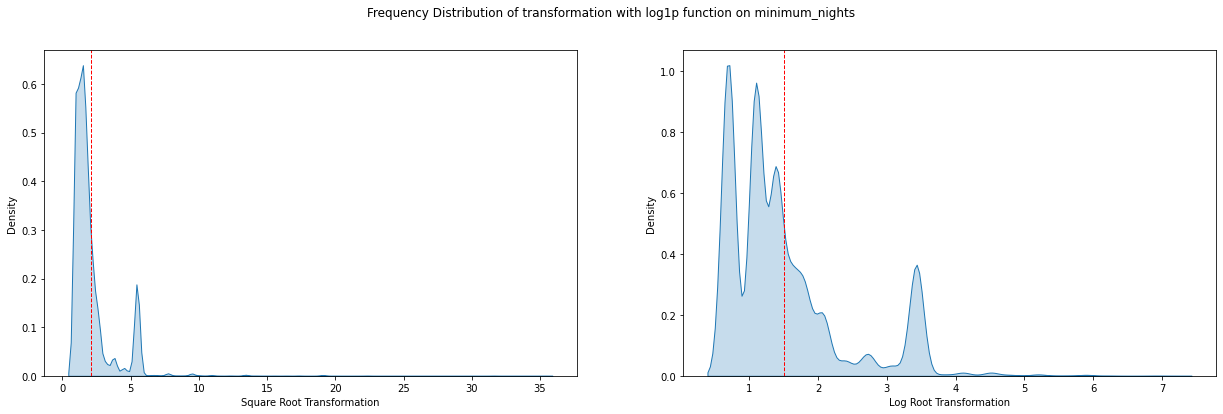

In [20]:
#To tackle the skewness in the minimum_nights variable, transformation being plotted to see if the data looks more normally distributed

fig, axes = plt.subplots(1,2, figsize=(21,6))
sns.kdeplot(np.sqrt(df_in['minimum_nights']), ax =axes[0], shade = True)
axes[0].axvline(x=(np.sqrt(df_in['minimum_nights'])).mean(), color='red', linestyle='dashed', linewidth=1)
axes[0].set_xlabel('Square Root Transformation')

sns.kdeplot(np.log1p(df_in['minimum_nights']), ax = axes[1], shade = True)
axes[1].axvline(x=(np.log1p(df_in['minimum_nights'])).mean(), color='red', linestyle='dashed', linewidth=1)
axes[1].set_xlabel('Log Root Transformation')

fig.suptitle('Frequency Distribution of transformation with log1p function on minimum_nights')

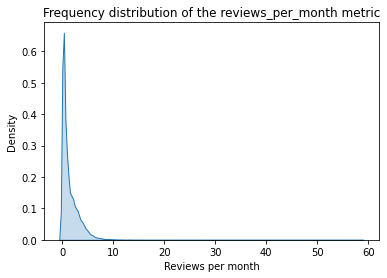

In [21]:
#Distribution plot of reviews_per_month that shows that there are a lot of properties with little or no reviews

plot = sns.kdeplot((df_in['reviews_per_month']), shade = True)

plot.set(title = 'Frequency distribution of the reviews_per_month metric')

plot.set(xlabel = 'Reviews per month')

plt.show()

In [23]:
#filling the NA values in reviews_per_month as zero

df_in['reviews_per_month'] = df_in['reviews_per_month'].fillna(0)

In [25]:
#Converting the last_review column in dataset as datetime format

df_in['last_review'] = pd.to_datetime(df_in['last_review'])

In [26]:
#converting the date column into number of days from a particular minimum date to make the variable more continuous

old = min(df_in['last_review'])
df_in['last_review'] = df_in['last_review'].fillna(old)
df_in['days_since_review'] = df_in['last_review'].apply(lambda x: x.toordinal() - old.toordinal())

In [27]:
df_in.price.describe()

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

In [28]:
df_in.minimum_nights.describe()

count    48895.000000
mean         7.029962
std         20.510550
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max       1250.000000
Name: minimum_nights, dtype: float64

In [29]:
'''Based on our transformation comparison chart, we are using the log1p transformation for the price & minimum_nights variables 
as log1p transformation takes care of small x values instead of returning NA when log transformation is used'''

df_in['price'] = np.log1p(df_in['price'])

In [30]:
df_in['minimum_nights_log'] = np.log1p(df_in['minimum_nights'])

In [31]:
df_in.reviews_per_month.describe()

count    48895.000000
mean         1.090910
std          1.597283
min          0.000000
25%          0.040000
50%          0.370000
75%          1.580000
max         58.500000
Name: reviews_per_month, dtype: float64

In [33]:
#Filtering for the dataframe to include only some subset of the reviews_per_month rows & availability data

df_in['reviews_per_month'] = df_in[df_in['reviews_per_month'] < 15]['reviews_per_month']

In [34]:
#Filtering for the dataframe to include only some subset of the reviews_per_month rows & availability data

df_in['year_avail'] = df_in['availability_365']>365

df_in['no_reviews'] = df_in['reviews_per_month']==0

In [35]:
df_in.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'days_since_review', 'minimum_nights_log',
       'year_avail', 'no_reviews'],
      dtype='object')

In [39]:
#dropping some unwanted columns before moving to the model implementation steps

df_out = df_in.drop(columns=['name', 'host_name','last_review','minimum_nights'])

In [40]:
df_out.columns

Index(['id', 'host_id', 'neighbourhood_group', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'days_since_review', 'minimum_nights_log',
       'year_avail', 'no_reviews'],
      dtype='object')

In [41]:
df_out['reviews_per_month'] = df_out['reviews_per_month'].fillna(0)

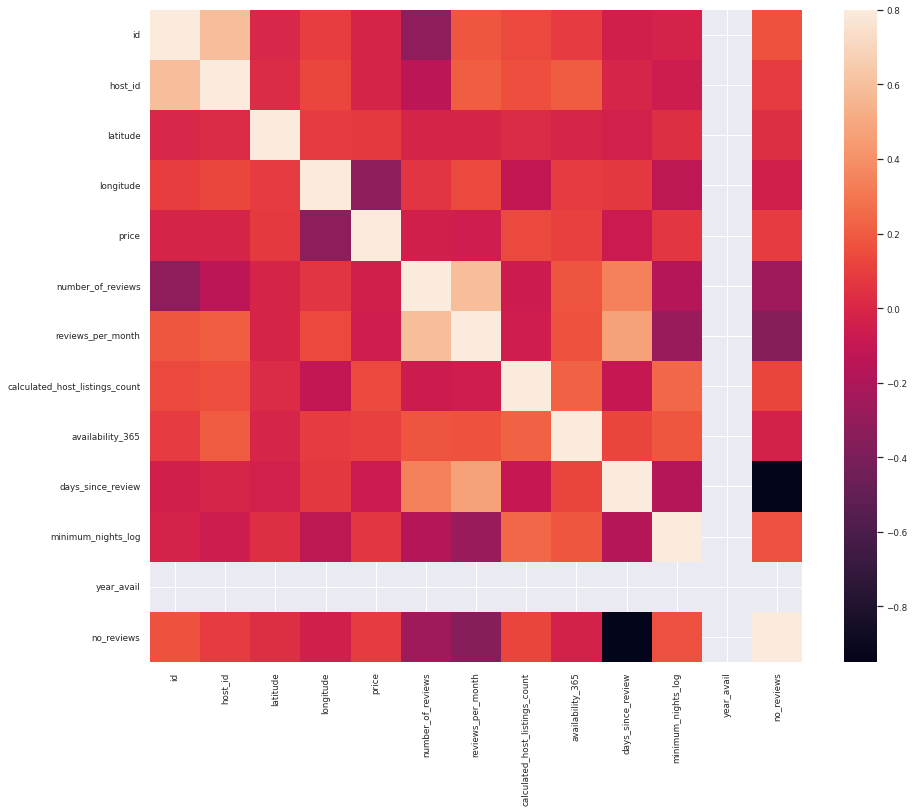

In [44]:
#Correlation matrix across all the variables to identify if there are columns that are strongly correlated
#In this dataframe we observe that there are not noticeable correlation among the columns

corrmatrix = df_out.corr()
f, ax = plt.subplots(figsize=(15,12))
sns.heatmap(corrmatrix, vmax=0.8, square=True)
sns.set(font_scale=0.8)

In [45]:
df_out.isnull().sum()

id                                0
host_id                           0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
days_since_review                 0
minimum_nights_log                0
year_avail                        0
no_reviews                        0
dtype: int64

#Feature Engineering

In [46]:
#Select only non-numeric variables to one-hot encoding process

categorical_features = df_out.select_dtypes(include=['object'])

In [47]:
#One-hot encoding using the pandas get_dummies function for all the categorical variables

categorical_features_one_hot = pd.get_dummies(categorical_features)
categorical_features_one_hot.head()

,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,neighbourhood_Allerton,neighbourhood_Arden Heights,neighbourhood_Arrochar,neighbourhood_Arverne,neighbourhood_Astoria,...,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [49]:
#Identifying the numerical features that can be used directly for the regression task
#Storing the price variable in a separate dataframe to use as y variable in prediction

numerical_features =  df_out.select_dtypes(exclude=['object'])
price_value = numerical_features.price
numerical_features = numerical_features.drop(['price'], axis=1)

In [50]:
#Final dataframe with the concatenation of categorical & numerical values is defined

final_df = pd.concat([numerical_features, categorical_features_one_hot], axis=1)

In [51]:
final_df.head(10)

,id,host_id,latitude,longitude,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,days_since_review,minimum_nights_log,...,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,2539,2787,40.64749,-73.97237,9,0.21,6,365,2762,0.693147,...,0,0,0,0,0,0,0,0,1,0
1,2595,2845,40.75362,-73.98377,45,0.38,2,355,2976,0.693147,...,0,0,0,0,0,0,0,1,0,0
2,3647,4632,40.80902,-73.94190,0,0.00,1,365,0,1.386294,...,0,0,0,0,0,0,0,0,1,0
3,3831,4869,40.68514,-73.95976,270,4.64,1,194,3021,0.693147,...,0,0,0,0,0,0,0,1,0,0
4,5022,7192,40.79851,-73.94399,9,0.10,1,0,2793,2.397895,...,0,0,0,0,0,0,0,1,0,0
5,5099,7322,40.74767,-73.97500,74,0.59,1,129,3008,1.386294,...,0,0,0,0,0,0,0,1,0,0
6,5121,7356,40.68688,-73.95596,49,0.40,1,0,2383,3.828641,...,0,0,0,0,0,0,0,0,1,0
7,5178,8967,40.76489,-73.98493,430,3.47,1,220,3010,1.098612,...,0,0,0,0,0,0,0,0,1,0
8,5203,7490,40.80178,-73.96723,118,0.99,1,0,2307,1.098612,...,0,0,0,0,0,0,0,0,1,0
9,5238,7549,40.71344,-73.99037,160,1.33,4,188,2995,0.693147,...,0,0,0,0,0,0,0,1,0,0


In [52]:
#Using the train_test_split of the sklearn package, we are splitting the dataframe & the price variable into test & training samples

X_train, X_test, y_train, y_test = train_test_split(final_df, price_value, test_size=0.2, random_state=42)

In [53]:
#Printing the shape of the test & train samples for our understanding

print('Dimensions of the training feature matrix: {}'.format(X_train.shape))
print('Dimensions of the training target vector: {}'.format(y_train.shape))
print('Dimensions of the test feature matrix: {}'.format(X_test.shape))
print('Dimensions of the test target vector: {}'.format(y_test.shape))

Dimensions of the training feature matrix: (39116, 241)
Dimensions of the training target vector: (39116,)
Dimensions of the test feature matrix: (9779, 241)
Dimensions of the test target vector: (9779,)


#Model Implementation

#RandomForestRegressor Model

##Skip directly to run the model from Drive location

In [54]:
#Defining the RandomForestRegressor as a function with some default parameters & printing the prediction results based on the fitting with test data
#r2_score & mean_squared_error functions are used as evaluation metrics for this regression task

def RandomForest(n_estimators = 100, max_depth = 5, max_features = 'sqrt', min_samples_split = 2, min_samples_leaf = 1,
                 max_leaf_nodes = None,bootstrap = True,oob_score = True):
    
    rf_model = RandomForestRegressor(n_estimators=n_estimators,
                                      max_depth=max_depth,
                                      max_features=max_features,
                                     min_samples_split = min_samples_split,
                                     min_samples_leaf = min_samples_leaf,
                                     max_leaf_nodes = max_leaf_nodes,
                                     bootstrap = bootstrap,
                                     oob_score = oob_score,                                     
                                      random_state=42)

    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)

    print('r2 score: ' + str(r2_score(y_test, y_pred)))
    print('rmse (units): ' + str(mean_squared_error(np.expm1(y_test), np.expm1(y_pred), squared=False)) + '\n')

In [55]:
#Based on a RandomForestRegressor model, the gridsearch function is defined for tuning the hyperparameters
#n_jobs = 4 determines the number of jobs that gridsearch can run in parallel thereby reducing processing time
#cv = 3 determining the 4-fold cross-validation as part of the training & validation within the training dataset

def RandomForest_tuning(n_estimators = 100, max_depth = 5, max_features = 'sqrt', min_samples_split = 2, min_samples_leaf = 1,
                        max_leaf_nodes = None,bootstrap = True,oob_score = True,
                        param_test={'n_estimators': [50, 100, 150, 200]}):
    
    rf_model = RandomForestRegressor(n_estimators=n_estimators,
                                      max_depth=max_depth,
                                      max_features=max_features,
                                     min_samples_split = min_samples_split,
                                     min_samples_leaf = min_samples_leaf,
                                     max_leaf_nodes = max_leaf_nodes,
                                     bootstrap = bootstrap,
                                     oob_score = oob_score,                                     
                                      random_state=42)
    
    gsearch = GridSearchCV(estimator=rf_model, 
                           param_grid=param_test, 
                           scoring='neg_mean_squared_error',
                           n_jobs=4, 
                           cv=3)

    gsearch.fit(X_train, y_train)
    return gsearch


In [ ]:
#Baseline RandomForestRegressor

RandomForest()

r2 score: 0.38946795223440234
rmse (units): 204.01518863087483



In [ ]:
#Step 1 Tuning n_estimators parameters
parameters_test = {
    'n_estimators': [500, 1000, 1500, 2000]
} 

gsearch1_rf = RandomForest_tuning(param_test=parameters_test)
best_n_est = gsearch1_rf.best_params_['n_estimators']
print(f"{gsearch1_rf.best_params_} Best Score: {gsearch1_rf.best_score_}")

# Evaluation
RandomForest(n_estimators = best_n_est)


{'n_estimators': 500} Best Score: -0.29295852288579327
r2 score: 0.4037170065171939
rmse (units): 203.73956621253498



In [ ]:
best_n_est = 1500

In [ ]:
#Step 2 Tuning max_depth parameters
parameters_test = {
    'max_depth': [3,5,7, 10]
} 

gsearch2_rf = RandomForest_tuning(n_estimators = 1500,param_test=parameters_test)
best_depth = gsearch2_rf.best_params_['max_depth']
print(f"{gsearch2_rf.best_params_} Best Score: {gsearch2_rf.best_score_}")

# Evaluation
RandomForest(n_estimators = best_n_est, max_depth = best_depth)

{'max_depth': 10} Best Score: -0.2368273673868511
r2 score: 0.5276688202765514
rmse (units): 198.77810289351459



In [ ]:
#Step 3 Tuning max_features parameters
parameters_test = {
    'max_features': ['sqrt', 'log2']
} 

gsearch3_rf = RandomForest_tuning(n_estimators = 1500,param_test=parameters_test)
best_features = gsearch3_rf.best_params_['max_features']
print(f"{gsearch3_rf.best_params_} Best Score: {gsearch3_rf.best_score_}")

# Evaluation
RandomForest(n_estimators = best_n_est, max_depth = best_depth, max_features = best_features)

{'max_features': 'sqrt'} Best Score: -0.2926804728306393
r2 score: 0.5055095828059684
rmse (units): 199.76833894099718



In [ ]:
#Step 4 Tuning min_samples_split parameters
parameters_test = {
    'min_samples_split': [2, 5, 10]
} 

gsearch4_rf = RandomForest_tuning(n_estimators = 1500,param_test=parameters_test)
best_min_split = gsearch4_rf.best_params_['min_samples_split']
print(f"{gsearch4_rf.best_params_} Best Score: {gsearch4_rf.best_score_}")

# Evaluation
RandomForest(n_estimators = best_n_est, max_depth = best_depth, max_features = best_features, min_samples_split = best_min_split)

{'min_samples_split': 5} Best Score: -0.2913715230603582
r2 score: 0.5090099982284558
rmse (units): 199.57790024715158



In [ ]:
#Step 5 Tuning min_samples_leaf parameters
parameters_test = {
    'min_samples_leaf': [1, 2, 4]
} 

gsearch5_rf = RandomForest_tuning(n_estimators = 1500,param_test=parameters_test)
best_min_leaf = gsearch5_rf.best_params_['min_samples_leaf']
print(f"{gsearch5_rf.best_params_} Best Score: {gsearch5_rf.best_score_}")

# Evaluation
RandomForest(n_estimators = best_n_est, max_depth = best_depth, max_features = best_features, min_samples_split = best_min_split,
             min_samples_leaf = best_min_leaf)

{'min_samples_leaf': 2} Best Score: -0.29177905844455143
r2 score: 0.5106711417654367
rmse (units): 199.53165383040925



In [ ]:
#Step 6 Tuning max_leaf_nodes parameters
parameters_test = {
    'max_leaf_nodes': [None, 5, 10]
} 

gsearch6_rf = RandomForest_tuning(n_estimators = 1500,param_test=parameters_test)
best_max_leaf = gsearch6_rf.best_params_['max_leaf_nodes']
print(f"{gsearch6_rf.best_params_} Best Score: {gsearch6_rf.best_score_}")

# Evaluation
RandomForest(n_estimators = best_n_est, max_depth = best_depth, max_features = best_features, min_samples_split = best_min_split,
             min_samples_leaf = best_min_leaf, max_leaf_nodes = best_max_leaf)

{'max_leaf_nodes': None} Best Score: -0.2926804728306393
r2 score: 0.5106711417654367
rmse (units): 199.53165383040925



In [ ]:
#Step 8 Tuning oob parameters
parameters_test = {
    'oob_score': [True, False]
} 

gsearch8_rf = RandomForest_tuning(n_estimators = 1500,param_test=parameters_test)
best_oob = gsearch8_rf.best_params_['oob_score']
print(f"{gsearch8_rf.best_params_} Best Score: {gsearch8_rf.best_score_}")

# Evaluation
RandomForest(n_estimators = best_n_est, max_depth = best_depth, max_features = best_features, min_samples_split = best_min_split,
             min_samples_leaf = best_min_leaf, max_leaf_nodes = best_max_leaf, bootstrap = True, oob_score = best_oob)

{'oob_score': True} Best Score: -0.2926804728306393
r2 score: 0.5106711417654367
rmse (units): 199.53165383040925



In [ ]:
#Running the RandomForestRegressor model with the identified best hyperparameters from the GridSearchCV operation

rf_model_best = RandomForestRegressor(n_estimators=1500,
                                  max_depth=30,
                                  max_features='sqrt',
                                  min_samples_split = 5,
                                  min_samples_leaf = 1,
                                  max_leaf_nodes = None,
                                  bootstrap = True,
                                  oob_score = False,                                     
                                  random_state=42)

rf_model_best.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, max_features='sqrt', min_samples_split=5,
                      n_estimators=1500, random_state=42)

In [ ]:
save_loc = '/content/drive/MyDrive/Ensemble_Project/rf_model_bestparams_20230318.joblib'

In [ ]:
# Save the trained model to a file
dump(rf_model_best, save_loc)

['/content/drive/MyDrive/Ensemble_Project/rf_model_bestparams_20230318.joblib']

##Run this step directly with the tuned hyperparameters

In [ ]:
save_loc = '/content/drive/MyDrive/Ensemble_Project/rf_model_bestparams_20230318.joblib'

In [ ]:
# Load the saved model from file
loaded_model_rf = load(save_loc)

In [ ]:
#Making predictions on the test data from the model that has been loaded from a pretrained model

y_pred = loaded_model_rf.predict(X_test)

print('r2 score: ' + str(r2_score(y_test, y_pred)))
print('rmse (units): ' + str(mean_squared_error(np.expm1(y_test), np.expm1(y_pred), squared=False)) + '\n')

r2 score: 0.6282915904851702
rmse (units): 189.655751546895



#XGBoost Regressor 

##skip directly to run the XGBoost model saved in Drive

In [ ]:
#Defining the XGBoostRegressor as a function with some default parameters & printing the prediction results based on the fitting with test data
#r2_score & mean_squared_error functions are used as evaluation metrics for this regression task

def XGBoost(LR = 0.01, n_estimators = 100, max_depth = 5, reg_alpha = 0, subsample = 1):
   
    xgb_model = XGBRegressor(learning_rate=LR,
                             n_estimators=n_estimators,
                             max_depth=max_depth,
                             reg_alpha=reg_alpha,
                             subsample=subsample,
                             random_state=42,
                             objective= 'reg:squarederror')

    xgb_model.fit(X_train, y_train, verbose=False)
    y_pred = xgb_model.predict(X_test)

    print('r2 score: ' + str(r2_score(y_test, y_pred)))
    print('rmse (units): ' + str(mean_squared_error(np.expm1(y_test), np.expm1(y_pred), squared=False)) + '\n')


In [ ]:
#Based on a XGBRegressor model, the gridsearch function is defined for tuning the hyperparameters
#n_jobs = 4 determines the number of jobs that gridsearch can run in parallel thereby reducing processing time
#cv = 3 determining the 4-fold cross-validation as part of the training & validation within the training dataset

def XGBoost_tuning(LR = 0.1, n_estimators = 100, max_depth = 5, reg_alpha = 0, subsample = 1, 
                   param_test = {'learning_rate':[i/100.0 for i in range(5,20,2)]}):
    
    xgb_model = XGBRegressor(learning_rate=LR,
                             n_estimators=n_estimators,
                             max_depth=max_depth,
                             reg_alpha=reg_alpha,
                             subsample=subsample,
                             random_state=42,
                             objective= 'reg:squarederror')

    gsearch = GridSearchCV(estimator=xgb_model, 
                           param_grid=param_test, 
                           scoring='neg_mean_squared_error',
                           n_jobs=4, 
                           cv=3)

    gsearch.fit(X_train, y_train, verbose = False)
    return gsearch

In [ ]:
LearningRate = 0.1
iterations = 1000

In [ ]:
#baseline XGboostregressor
XGBoost(LR = LearningRate, n_estimators = iterations)

r2 score: 0.6312345539596449
rmse (units): 181.6322469155302



In [ ]:
# STEP 2 - Tuning LR

parameters_test = {
    'learning_rate': [0.001, 0.01, 0.1]
} 

gsearch2_xg = XGBoost_tuning (n_estimators = iterations, param_test=parameters_test)
best_lr = gsearch2_xg.best_params_['learning_rate']
print(f"{gsearch2_xg.best_params_} Best Score: {gsearch2_xg.best_score_}")

# Evaluation
XGBoost(LR = best_lr, n_estimators = iterations)

{'learning_rate': 0.1} Best Score: -0.19161392885108422
r2 score: 0.6312345539596449
rmse (units): 181.6322469155302



In [ ]:
# STEP 3 - Tuning number of estimators

parameters_test = {
    'n_estimators': [100, 500, 1000]
} 

gsearch3_xg = XGBoost_tuning (LR = best_lr, param_test=parameters_test)
best_est = gsearch3_xg.best_params_['n_estimators']
print(f"{gsearch3_xg.best_params_} Best Score: {gsearch3_xg.best_score_}")

# Evaluation
XGBoost(LR = best_lr, n_estimators = best_est)

{'n_estimators': 500} Best Score: -0.19121141978804604


In [ ]:
best_lr  = 0.1
best_est = 500

In [ ]:
# STEP 4 - Tuning Max_Depth

parameters_test = {
    'max_depth': [3, 5, 7]
} 

gsearch4_xg = XGBoost_tuning (LR = best_lr, n_estimators = best_est, param_test=parameters_test)
best_depth = gsearch4_xg.best_params_['max_depth']
print(f"{gsearch4_xg.best_params_} Best Score: {gsearch4_xg.best_score_}")

# Evaluation
XGBoost(LR = best_lr, n_estimators = best_est, max_depth = best_depth)

{'max_depth': 7} Best Score: -0.19014960724520244
r2 score: 0.6376699487427047
rmse (units): 180.59877263181784



In [ ]:
# STEP 5 - Tuning subsample

parameters_test = {
    'subsample': [0.5, 0.75, 1]
} 

gsearch5_xg = XGBoost_tuning (LR = best_lr, n_estimators = best_est, param_test=parameters_test)
best_sub = gsearch5_xg.best_params_['subsample']
print(f"{gsearch5_xg.best_params_} Best Score: {gsearch5_xg.best_score_}")

# Evaluation
XGBoost(LR = best_lr, n_estimators = best_est, max_depth = best_depth, subsample = best_sub)

{'subsample': 0.75} Best Score: -0.19032707780722533
r2 score: 0.6401128024473707
rmse (units): 181.04760771604407



In [ ]:
# STEP 6 - Tuning reg alpha

parameters_test = {
    'reg_alpha': [0, 0.1, 0.5]
} 

gsearch6_xg = XGBoost_tuning (LR = best_lr, n_estimators = best_est, param_test=parameters_test)
best_alpha = gsearch6_xg.best_params_['reg_alpha']
print(f"{gsearch6_xg.best_params_} Best Score: {gsearch6_xg.best_score_}")

# Evaluation
XGBoost(LR = best_lr, n_estimators = best_est, max_depth = best_depth, subsample = best_sub, reg_alpha = best_alpha)

{'reg_alpha': 0.5} Best Score: -0.1897969373671422
r2 score: 0.6396263493413368
rmse (units): 182.06011093321067



In [ ]:
xgb_model_best = XGBRegressor(learning_rate=0.1,
                          n_estimators=500,
                          max_depth=7,
                          reg_alpha=0.5,
                          subsample=0.75,
                          random_state=42,
                          objective= 'reg:squarederror')

xgb_model_best.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [ ]:
with open(save_loc, 'wb') as file:
    pickle.dump(xgb_model_best, file)

##run this step to use model from Drive

In [ ]:
save_loc = '/content/drive/MyDrive/Ensemble_Project/xgboostmodel_bestparameters_20230317.pkl'

In [ ]:
#Loading the pretrained XGBRegressor model for this dataset from drive location

with open(save_loc, 'rb') as file:
    loaded_model_xgb = pickle.load(file)

In [ ]:
#Prediction made on the test dataset using the pretrained model & accuracy of the model is identified

y_pred = loaded_model_xgb.predict(X_test)

print('r2 score: ' + str(r2_score(y_test, y_pred)))
print('rmse (units): ' + str(mean_squared_error(np.expm1(y_test), np.expm1(y_pred), squared=False)) + '\n')

r2 score: 0.6396263493413368
rmse (units): 182.06011093321067



##catboost preprocessing steps

In [57]:
#Storing the x and y variables for the regression task into 2 different dataframes

df_x = df_out.drop(columns=['price'], axis = 1)
df_y = df_out['price']

In [59]:
#Sampling of the X and Y variables for the test & training part using train_test_split function

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(df_x, df_y, test_size=0.2, random_state=42)

In [60]:
#To train the catboost model, the input test & training data is converted to pool format by specifically calling out categorical variables too

train_pool = Pool(X_train_cat, y_train_cat, cat_features = ['neighbourhood_group', 'neighbourhood','room_type'])
test_pool = Pool(X_test_cat, y_test_cat, cat_features = ['neighbourhood_group', 'neighbourhood','room_type'])

###skip directly to use the model saved in Drive

In [61]:
#Defining the CatBoostRegressor as a function with some default parameters & printing the prediction results based on the fitting with test data
#r2_score & mean_squared_error functions are used as evaluation metrics for this regression task

def CatBoost(LR = 0.01, itr = 1000, dep = 5, l2_val = 0.1, subs = 1, bt = 0.1):
   
    cb_model = CatBoostRegressor(learning_rate=LR,
                                 iterations=itr,
                                 depth =dep,
                                 l2_leaf_reg=l2_val,
                                 subsample=subs,
                                 bagging_temperature = bt,
                                 random_state=42,
                                 loss_function= 'RMSE')

    cb_model.fit(train_pool, verbose=False)
    y_pred = cb_model.predict(test_pool)

    print('r2 score: ' + str(r2_score(y_test, y_pred)))
    print('rmse (units): ' + str(mean_squared_error(np.expm1(y_test), np.expm1(y_pred), squared=False)) + '\n')

In [62]:
#Based on a CatBoostRegressor model, the gridsearch function is defined for tuning the hyperparameters
#n_jobs = 4 determines the number of jobs that gridsearch can run in parallel thereby reducing processing time
#cv = 3 determining the 4-fold cross-validation as part of the training & validation within the training dataset

def CatBoost_tuning (LR = 0.1, itr = 1000, dep = 5, l2_val = 0.1, subs = 1, bt = 0.1, 
                     param_test = {'learning_rate':[i/100.0 for i in range(5,20,2)]} ):
    
    gsearch = GridSearchCV(estimator = CatBoostRegressor(learning_rate=LR,
                                                         iterations=itr,
                                                         depth =dep,
                                                         l2_leaf_reg=l2_val,
                                                         subsample=subs,
                                                         bagging_temperature = bt,
                                                         random_state=42,
                                                         loss_function= 'RMSE'), 
                            param_grid = param_test, 
                            scoring='neg_mean_squared_error',
                            n_jobs=4, 
                            cv=3)

    gsearch.fit(X_train, y_train, verbose = False)
    return gsearch


In [ ]:
LearningRate = 0.1
iterations = 1000

In [ ]:
#baseline Catboost
CatBoost(LR = LearningRate, itr = iterations)

r2 score: 0.6381536705935184
rmse (units): 181.11701131932242



In [ ]:
# STEP 2 - Tuning Depth parameter

parameters_test = {
    'depth':[3,5,7,9]
}

gsearch2_cb = CatBoost_tuning (LR = LearningRate, itr = iterations, param_test=parameters_test)
best_depth = gsearch2_cb.best_params_['depth']
print(f"{gsearch2_cb.best_params_} Best Score: {gsearch2_cb.best_score_}")

# Evaluation
CatBoost(LR = LearningRate, itr = iterations, dep = best_depth)

{'depth': 7} Best Score: -0.18826006063105785
r2 score: 0.6431288227399761
rmse (units): 179.36732661474687



In [ ]:
# STEP 3 - Tuning L2 Regularization parameter

parameters_test = {
    'l2_leaf_reg': [0.01, 0.1, 0.5, 1, 2, 5]
}

gsearch3_cb = CatBoost_tuning (LR = LearningRate, itr = iterations, param_test=parameters_test)
best_l2 = gsearch3_cb.best_params_['l2_leaf_reg']
print(f"{gsearch3_cb.best_params_} Best Score: {gsearch3_cb.best_score_}")

# Evaluation
CatBoost(LR = LearningRate, itr = iterations, dep = best_depth, l2_val = best_l2)

{'l2_leaf_reg': 2} Best Score: -0.1890203053837631
r2 score: 0.6433264383389801
rmse (units): 180.4910180066357



In [ ]:
# STEP 4 - Tuning subsamples parameter

parameters_test = {
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

gsearch4_cb = CatBoost_tuning (LR = LearningRate, itr = iterations, param_test=parameters_test)
best_sub = gsearch4_cb.best_params_['subsample']
print(f"{gsearch4_cb.best_params_} Best Score: {gsearch4_cb.best_score_}")

# Evaluation
CatBoost(LR = LearningRate, itr = iterations, dep = best_depth, l2_val = best_l2, subs = best_sub)

{'subsample': 0.8} Best Score: -0.1899458633050087
r2 score: 0.6442433317289746
rmse (units): 182.73123950273987



In [ ]:
# STEP 5 - Tuning Bagging Temperature parameter

parameters_test = {
    'bagging_temperature': [0, 0.1, 0.5, 1, 2]
}

gsearch5_cb = CatBoost_tuning (LR = LearningRate, itr = iterations, param_test=parameters_test)
best_bt = gsearch5_cb.best_params_['bagging_temperature']
print(f"{gsearch5_cb.best_params_} Best Score: {gsearch5_cb.best_score_}")

# Evaluation
CatBoost(LR = LearningRate, itr = iterations, dep = best_depth, l2_val = best_l2, subs = best_sub, bt = best_bt)

{'bagging_temperature': 0} Best Score: -0.19049072659340863
r2 score: 0.6442433317289746
rmse (units): 182.73123950273987



In [ ]:
# STEP 6 - Tuning iterations

parameters_test = {
    'iterations': [500, 1000, 1500, 2000]
}

gsearch6_cb = CatBoost_tuning (LR = LearningRate, param_test=parameters_test)
best_itr = gsearch6_cb.best_params_['iterations']
print(f"{gsearch6_cb.best_params_} Best Score: {gsearch6_cb.best_score_}")

# Evaluation
CatBoost(LR = LearningRate, itr = best_itr, dep = best_depth, l2_val = best_l2, subs = best_sub, bt = best_bt)

{'iterations': 1500} Best Score: -0.19041914197830642
r2 score: 0.6449879799195477
rmse (units): 181.94821195561406



In [ ]:
# STEP 7 - Tuning LR

parameters_test = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.15, 0.2]
}

gsearch7_cb = CatBoost_tuning (LR = LearningRate, param_test=parameters_test)
best_lr = gsearch7_cb.best_params_['learning_rate']
print(f"{gsearch7_cb.best_params_} Best Score: {gsearch7_cb.best_score_}")

# Evaluation
CatBoost(LR = best_lr, itr = best_itr, dep = best_depth, l2_val = best_l2, subs = best_sub, bt = best_bt)

{'learning_rate': 0.1} Best Score: -0.19049072659340863
r2 score: 0.6449879799195477
rmse (units): 181.94821195561406



###best Catboost based on the parameters obtained

In [ ]:
best_cb_model = CatBoostRegressor(learning_rate=0.1,
                              iterations= 1500,
                              depth =7,
                              l2_leaf_reg=2,
                              subsample=0.8,
                              bagging_temperature = 0,
                              random_state=42,
                              loss_function= 'RMSE')

best_cb_model.fit(train_pool, verbose=False)

save_loc = '/content/drive/MyDrive/Ensemble_Project/catboostmodel_bestparams_20230317.cbm'

best_cb_model.save_model(save_loc)

###run this step to use pretrained Catboost model

In [ ]:
save_loc = '/content/drive/MyDrive/Ensemble_Project/catboostmodel_bestparams_20230317.cbm'

In [ ]:
#Loading the pretrained catboostregressor model into a variable and using it to make prediction on the test dataset

loaded_model_cb = CatBoostRegressor()

loaded_model_cb.load_model(save_loc)

y_pred = loaded_model_cb.predict(test_pool)

print('r2 score: ' + str(r2_score(y_test, y_pred)))
print('rmse (units): ' + str(mean_squared_error(np.expm1(y_test), np.expm1(y_pred), squared=False)) + '\n')

r2 score: 0.6449879799195477
rmse (units): 181.94821195561406



### CatBoostRegressor giving the better performance in terms of the prediction r2_score & RMSE and also being the fastest among all for training on the dataset

#RandomForestRegressor Feature Importance

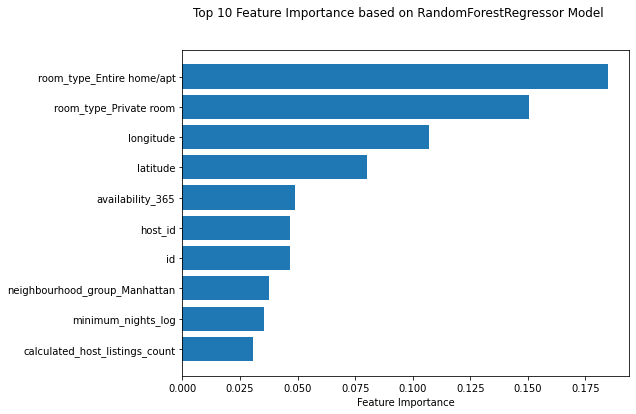

In [ ]:
# Calculate and plot the feature importance for RandomForestRegressor
importance_rf = loaded_model_rf.feature_importances_
feature_names_rf = X_train.columns.tolist()

feature_importance_df_rf = pd.DataFrame({'feature': feature_names_rf, 'importance': importance_rf})
top10 = feature_importance_df_rf.nlargest(10, 'importance')
top10 = top10.iloc[::-1]

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(top10['feature'], top10['importance'])
ax.set_xlabel('Feature Importance')
fig.suptitle('Top 10 Feature Importance based on RandomForestRegressor Model')
plt.show()


#XGBoostRegressor Feature Importance

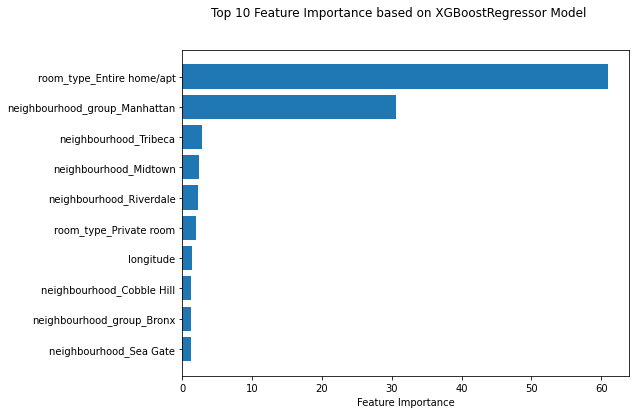

In [ ]:
# Calculate and plot the feature importance for XGBoostRegressor using the get_score method
importance_xgb = loaded_model_xgb.get_booster().get_score(importance_type='gain')
feature_names_xgb = X_train.columns.tolist()

feature_importance_df_xgb = pd.DataFrame({'feature': feature_names_xgb, 'importance': [importance_xgb.get(name, 0) for name in feature_names_xgb]})
top10 = feature_importance_df_xgb.nlargest(10, 'importance')
top10 = top10.iloc[::-1]

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(top10['feature'], top10['importance'])
ax.set_xlabel('Feature Importance')
fig.suptitle('Top 10 Feature Importance based on XGBoostRegressor Model')
plt.show()

#Catboost Feature Importance & SHAP Values

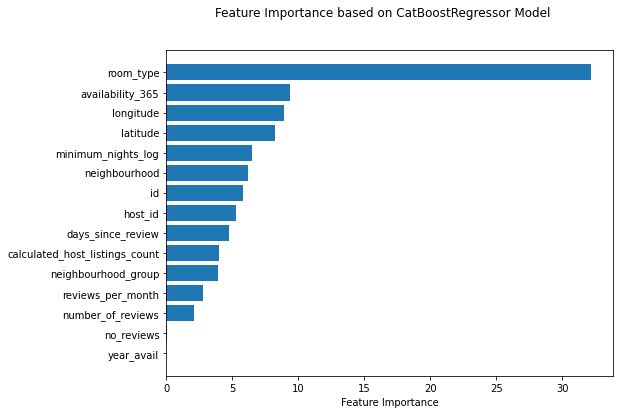

In [ ]:
# Calculate and plot the feature importance using the get_feature_importance method for CatBoostRegressor model
feature_importances = loaded_model_cb.get_feature_importance()
feature_names = X_train_cat.columns.tolist()

feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(feature_importance_df['feature'], feature_importance_df['importance'])
ax.set_xlabel('Feature Importance')
fig.suptitle('Feature Importance based on CatBoostRegressor Model')
plt.show()

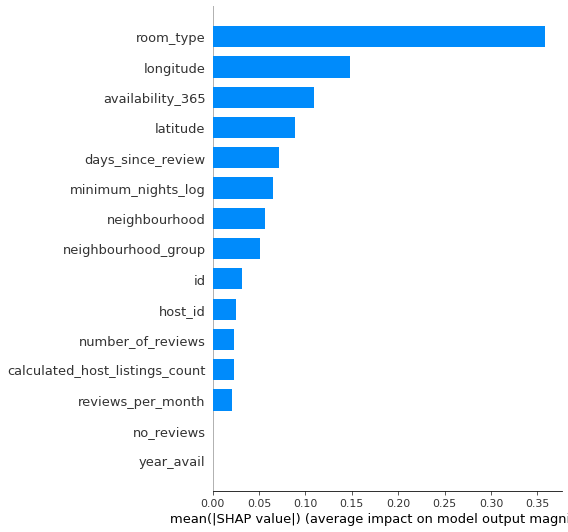

In [ ]:
# Calculate the SHAP values for each feature using the shap library
explainer = shap.Explainer(loaded_model_cb)
shap_values = explainer(X_train_cat)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_train_cat, plot_type="bar")
plt.show()